# Milestone 4b: Implement and Train an LSTM Model
> Author: Tien Ly  
> Created: July 2024

## Objective:

The goal of this notebook is to modify the attention-based Long Short-Term Memory (LSTM) network by adding a new feature—sea ice thickness—for predicting monthly sea ice extent with a 1-month lead time. The original architecture, its reference journal article, and the sea ice thickness data processing can be found in the python notebook, [milestone4/milestone4a.ipynb](milestone4/milestone4a.ipynb). 

The workflow involves:

1. **Preprocessing Data:**
  - Loading and preparing the dataset, including adding lags to target values
  - Normalizing features and targets for effective model training

2. **Model Implementation:**
  - Constructing an LSTM model with an attention mechanism to enhance the prediction accuracy by focusing on relevant features
  - Defining the model architecture, including LSTM layers and dense layers with appropriate activation functions

3. **Model Training:**
  - Compiling and training the model using historical sea ice data
  - Implementing callbacks for early stopping and model checkpointing

4. **Evaluation:**
  - Predicting sea ice extent on both training and validation datasets
  - Inverting scaling to interpret predictions in the original scale
  - Evaluating model performance using metrics such as RMSE, NRMSE, and R²

5. **Visualization:**
  - Creating plots to visualize the training and validation losses, as well as the predicted versus observed sea ice extent


This notebook aims to demonstrate the application of deep learning techniques for time series forecasting in climate science and to assess the model's effectiveness in predicting sea ice extent.

## Polar Sea Ice Prediction

In [1]:
from numpy.random import seed
seed(1)

## Initial Setup

In [2]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras imports for building and training the model
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Attention layer
from keras.layers import Attention
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Combined Data 1979-2018

* Features: wind_10m, specific_humidity, LW_down, SW_down, rainfall, snowfall, sosaline, sst, t2m, surface_pressure, sea_ice_extent
* Added feature: sit


In [3]:
# Upload the data and target files
from google.colab import files

files.upload()

Saving updated_monthly_features.npy to updated_monthly_features.npy
Saving updated_monthly_target.npy to updated_monthly_target.npy


{'updated_monthly_features.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': True, \'shape\': (480, 1, 12), }                                                     \n\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\xb6\x81[\xe2?\x8e\xe38\x

In [4]:
data = np.load('updated_monthly_features.npy', allow_pickle=True)
target = np.load('updated_monthly_target.npy', allow_pickle=True)

### Adding Lag to Y Values
Here, we introduce a lag of 1 month. This setup helps in training the model to predict the next time step based on the current time step’s data. For example, when we use the features from month 1, we are predicting the target for month 2.


In [5]:
# Adding a lag to monthly targets
lag = 1
data = data[:-lag, :, :]
target = target[lag:]

print(data.shape)
print(target.shape)

(479, 1, 12)
(479,)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the CSV file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [6]:
# Sequential split train:val data in 80:20 sequentially

LEN_DATA = len(data) # total number of data points (time steps)

NUM_TRAIN = LEN_DATA - (24 + 6) # reserve last 30 months for testing
NUM_VALID = LEN_DATA - NUM_TRAIN

print('LEN_DATA:', LEN_DATA)
print('NUM_TRAIN:', NUM_TRAIN)
print('NUM_VALID:', NUM_VALID)

x_train = data[0:NUM_TRAIN] # features for training
x_valid = data[NUM_TRAIN:] # features for validation

# Split features and labels
y_train = target[:NUM_TRAIN] # targets for training
y_valid = target[NUM_TRAIN:] # targets for validation


LEN_DATA: 479
NUM_TRAIN: 449
NUM_VALID: 30


In [7]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_valid.shape:', y_valid.shape)

x_train.shape: (449, 1, 12)
y_train.shape: (449,)
x_valid.shape: (30, 1, 12)
y_valid.shape: (30,)


## Reshaping Input and Target Features

In [8]:
# Convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [9]:
# Normalize the features
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1, x_train.shape[2])) # reshaping to 2d for standard scaling
x_valid = scaler_f.transform(x_valid.reshape(-1, x_valid.shape[2])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1, 1)) # reshaping to 2d for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1, 1)) # reshaping to 2d for standard scaling

In [10]:
# All data will be in 2D after standard scaling
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_valid.shape:', y_valid.shape)

x_train.shape: (449, 12)
y_train.shape: (449, 1)
x_valid.shape: (30, 12)
y_valid.shape: (30, 1)


In [11]:
# Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_valid = reshape_features(x_valid, timesteps) # reshaping to 3d for model


(449, 12)
(30, 12)


In [12]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_valid.shape:', y_valid.shape)

x_train.shape: (449, 1, 12)
y_train.shape: (449, 1)
x_valid.shape: (30, 1, 12)
y_valid.shape: (30, 1)


## LSTM Network

In [13]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Attention, Flatten, Concatenate
from tensorflow.keras.models import load_model, Model

# Define the timesteps and number of features
timestep = 1  # number of time steps per sample
features = 12

# Define the model architecture
model_input = Input(shape=(timestep, features)) # input layer

# Add LSTM layers with dropout for regularization
x = LSTM(64, return_sequences=True)(model_input) # LSTM layer with 64 units
x = Dropout(0.2)(x) # dropout layer to prevent overfitting

x = LSTM(32, return_sequences=True)(x)  # LSTM layer with 32 units
x = LSTM(16, return_sequences=True)(x)  # LSTM layer with 16 units
x = LSTM(16, return_sequences=True)(x)  # another LSTM layer with 16 units

# Attention mechanism
attention = Attention()([x, x])  # apply attention to the LSTM outputs
context_vector = Concatenate(axis=-1)([x, attention])  # concatenate the original and attention outputs
context_vector = Dropout(0.2)(context_vector)  # dropout layer for regularization
# Flatten the context vector for the Dense layers
flattened_context = Flatten()(context_vector)

# Dense layers to produce the final output
x = Dense(32, activation='relu')(flattened_context)  # dense layer with 32 units
x = Dense(16, activation='relu')(x)  # dense layer with 16 units
x = Dense(1)(x)  # output layer with 1 unit

# Define and compile the model
model = Model(model_input, x)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 12)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 64)          │         19,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1, 64)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 32)          │         12,416 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 16)          │          3,136 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 16)          │          2,112 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1, 16)          │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1, 32)          │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 32)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32)             │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          1,056 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             17 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
extent = target
print(extent.shape)

(479,)


## Compiling the Network and Fitting Model

In [15]:
# Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path = './testmodel.keras'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [16]:
history = model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=12,
    verbose=2,
    validation_split=0.3,
    shuffle=True,
    callbacks=keras_callbacks
)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


27/27 - 10s - 365ms/step - loss: 0.9081 - val_loss: 1.1251
Epoch 2/500
27/27 - 0s - 11ms/step - loss: 0.7053 - val_loss: 0.3867
Epoch 3/500
27/27 - 0s - 11ms/step - loss: 0.2530 - val_loss: 0.1768
Epoch 4/500
27/27 - 1s - 20ms/step - loss: 0.0923 - val_loss: 0.1275
Epoch 5/500
27/27 - 0s - 17ms/step - loss: 0.0607 - val_loss: 0.1370
Epoch 6/500
27/27 - 0s - 18ms/step - loss: 0.0496 - val_loss: 0.0779
Epoch 7/500
27/27 - 0s - 18ms/step - loss: 0.0438 - val_loss: 0.0711
Epoch 8/500
27/27 - 1s - 22ms/step - loss: 0.0352 - val_loss: 0.0624
Epoch 9/500
27/27 - 0s - 12ms/step - loss: 0.0307 - val_loss: 0.0453
Epoch 10/500
27/27 - 0s - 10ms/step - loss: 0.0291 - val_loss: 0.0654
Epoch 11/500
27/27 - 0s - 11ms/step - loss: 0.0242 - val_loss: 0.0698
Epoch 12/500
27/27 - 0s - 10ms/step - loss: 0.0246 - val_loss: 0.0523
Epoch 13/500
27/27 - 0s - 11ms/step - loss: 0.0239 - val_loss: 0.0473
Epoch 14/500
27/27 - 0s - 14ms/step - loss: 0.0222 - val_loss: 0.0434
Epoch 15/500
27/27 - 0s - 11ms/step - l

## Model Predictions

In [17]:
trainPred = model.predict(x_train)
testPred = model.predict(x_valid)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [18]:
print(testPred.shape)
print(trainPred.shape)

(30, 1)
(449, 1)


In [19]:
# Reverting data back to 2D from 3D
x_valid_t = x_valid.reshape((x_valid.shape[0], x_valid.shape[2]))
print(x_valid_t.shape)
print(testPred.shape)

(30, 12)
(30, 1)


Here, we reverse the normalization applied to the predicted values and actual values, so they can be compared in their original scale.

In [21]:
# Invert scaling for forecasted values
inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[1])

# Invert scaling for actual values
inv_y_valid = scaler_l.inverse_transform(y_valid)
print(inv_y_valid[1])

[6525289.]
[5595206.]


In [22]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 876238.346


In [23]:
# Calculate the normalized RMSE
y_max = inv_y_valid.max()
y_min = inv_y_valid.min()
nrmse = rmse / (inv_y_valid.mean())
print('Test normalized RMSE:', nrmse)

Test normalized RMSE: 0.0873402042745424


In [25]:
# Calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test R_Square: 0.930


## Plotting

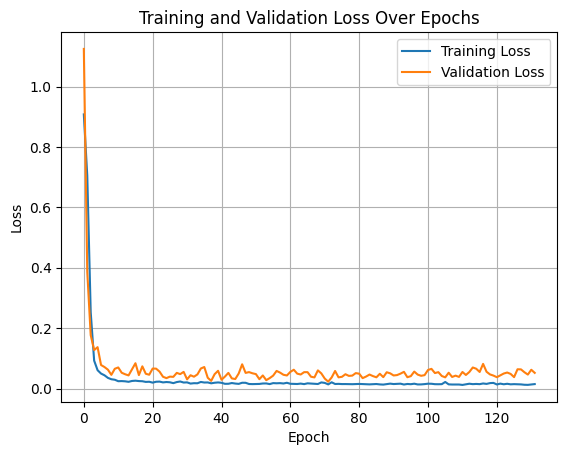

In [47]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')

pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.title('Training and Validation Loss Over Epochs')

pyplot.grid(True)
pyplot.legend()
pyplot.show()

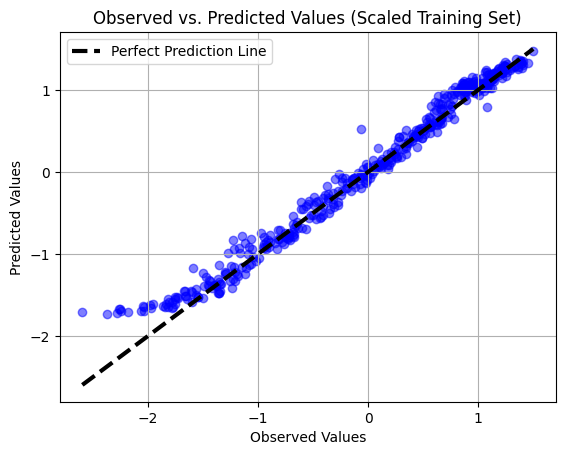

In [38]:
fig, ax = plt.subplots()
ax.scatter(y_train, trainPred, color='blue', alpha=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3, label='Perfect Prediction Line')

ax.set_xlabel('Observed Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Observed vs. Predicted Values (Scaled Training Set)')

ax.grid(True)
ax.legend()
plt.show()

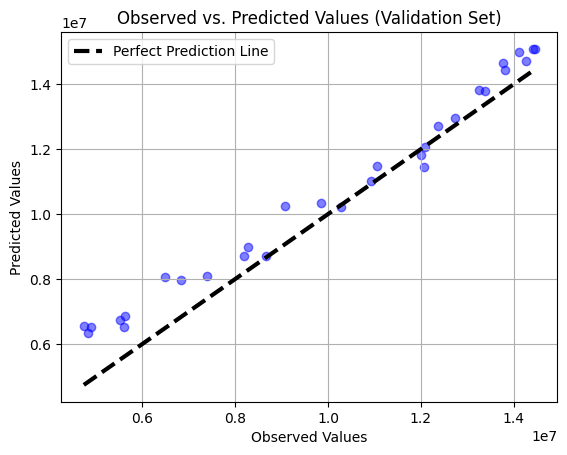

In [39]:
fig, ax = plt.subplots()
ax.scatter(inv_y_valid, inv_testPred, color='blue', alpha=0.5)
ax.plot([inv_y_valid.min(), inv_y_valid.max()], [inv_y_valid.min(), inv_y_valid.max()], 'k--', lw=3, label='Perfect Prediction Line')

ax.set_xlabel('Observed Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Observed vs. Predicted Values (Validation Set)')

ax.grid(True)
ax.legend()
plt.show()

In [40]:
trainPred = np.transpose(trainPred.flatten())

print(trainPred.shape)
print(y_train.shape)

(449,)
(449, 1)


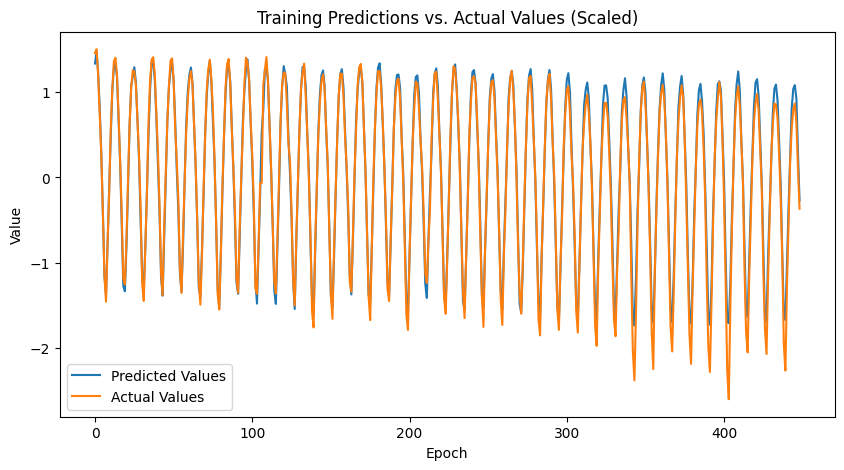

In [46]:
from matplotlib import pyplot

plt.figure(figsize=(10, 5))
plt.plot(trainPred, label='Predicted Values')
plt.plot(y_train, label='Actual Values')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Predictions vs. Actual Values (Scaled)')

plt.legend()
plt.show()

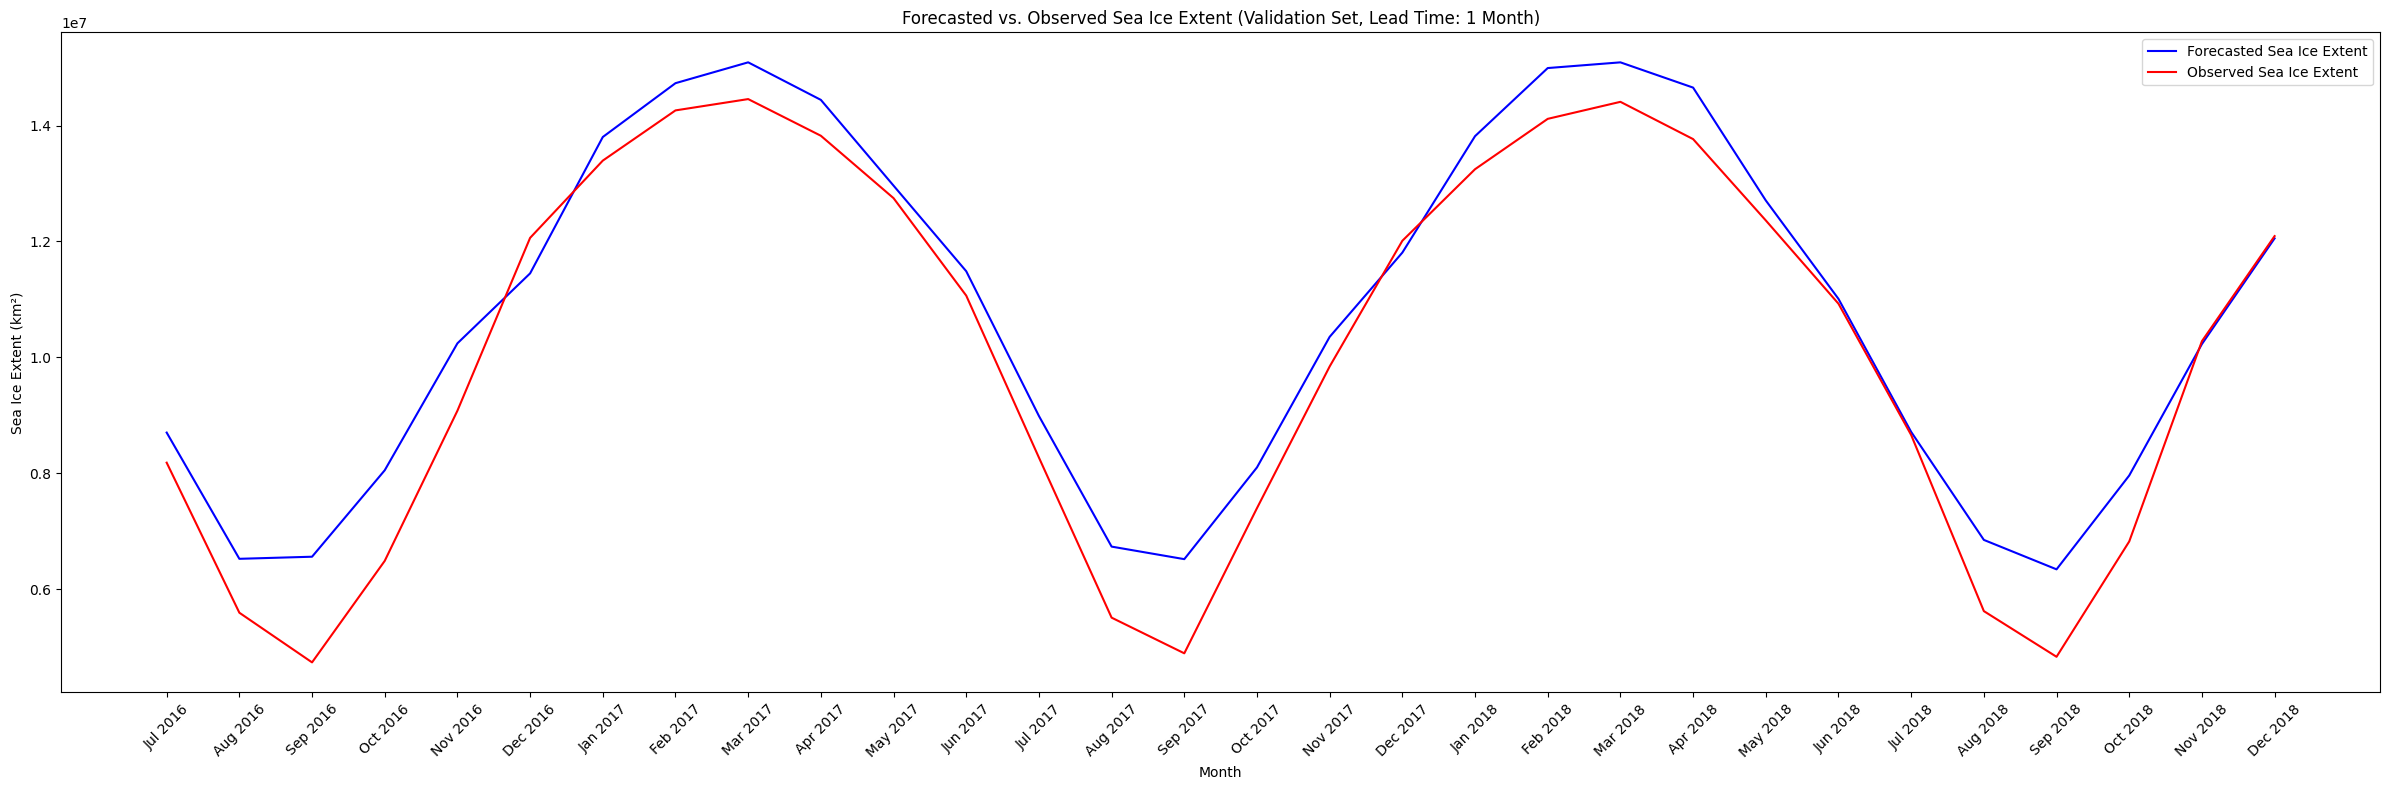

In [61]:
from matplotlib import pyplot

# The last 30 months correspond to your validation period
months = pd.date_range(start='2016-07-01', end='2018-12-01', freq='MS').strftime('%b %Y')

fig, ax = plt.subplots(figsize=(24, 8))

# Plot the forecasted and actual sea ice extents
ax.plot(inv_testPred, label='Forecasted Sea Ice Extent', color='blue')
ax.plot(inv_y_valid, label='Observed Sea Ice Extent', color='red')

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=45)

ax.set_xlabel('Month')
ax.set_ylabel('Sea Ice Extent (km²)')
ax.set_title('Forecasted vs. Observed Sea Ice Extent (Validation Set, Lead Time: 1 Month)')
ax.legend()

plt.tight_layout()
plt.show()